# Bayesian DAE vs Traditional DAE (Linear)


## Data loading and processing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


#Set random seed
torch.manual_seed(42)
np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

image_size = 128

class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.jpeg') or fname.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        image.draft('L', (image_size, image_size))

        if self.transform:
            image = self.transform(image)

        # If you have labels, modify this part to return the corresponding label as well.
        return (image, 0)

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/mri_dataset'

# Define any transformations (e.g., normalization, resizing)
transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Create an instance of the dataset
xray_dataset = MRIDataset(root_dir=dataset_path, transform=transform)

print(len(xray_dataset))

# Split dataset into train/validation/test sets
train_indices, temp_indices = train_test_split(np.arange(len(xray_dataset)), test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Create data loaders
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

train_loader = DataLoader(xray_dataset, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(xray_dataset, batch_size=64, sampler=val_sampler)
test_loader = DataLoader(xray_dataset, batch_size=64, sampler=test_sampler)

# Checking dataset sizes
print(f'Training dataset size: {len(train_sampler)}')
print(f'Validation dataset size: {len(val_sampler)}')
print(f'Test dataset size: {len(test_sampler)}')

print(len(train_loader))

6400
Training dataset size: 4480
Validation dataset size: 960
Test dataset size: 960
70


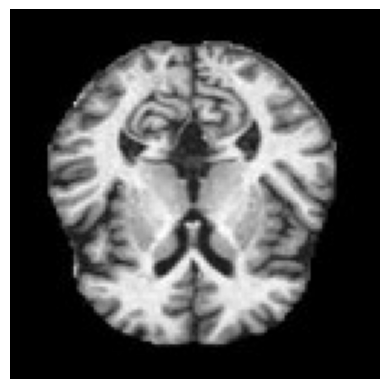

In [5]:
# Get the first batch of data
data_iter = iter(train_loader)
images, _ = next(data_iter)

# Extract the first image from the batch
first_image = images[0]

# Convert tensor to image
first_image = first_image.squeeze().numpy()  # Squeeze removes the single channel dimension
# first_image = first_image * 255  # Undo normalization

# Plot the image
plt.imshow(first_image, cmap='gray')
plt.axis('off')
plt.show()

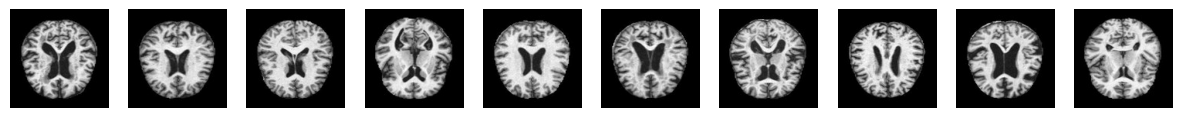

In [6]:
# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

## Autoencoder Architectures

In [7]:
dropout_rate = 0.1

def MC_dropout(act_vec, p=0.5, mask=True):
  return F.dropout(act_vec, p=p, training=mask, inplace=False)

class ConvolutionalBDAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv3 = nn.Conv2d(128, 256, 7)  # Increased number of output channels

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)  # Increased number of input channels
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.deconv2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], image_size*image_size)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, image_size*image_size)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, image_size, image_size)
      predictions_var = predictions_var.view(-1, 1, image_size, image_size)

      return predictions, predictions_mean, predictions_var


class ConvolutionalDAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv3 = nn.Conv2d(128, 256, 7)  # Increased number of output channels

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)  # Increased number of input channels
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=0.1, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.deconv2(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], image_size*image_size)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, image_size*image_size)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, image_size, image_size)
      predictions_var = predictions_var.view(-1, 1, image_size, image_size)

      return predictions, predictions_mean, predictions_var

## Noise schemes

In [8]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

## Training Process

### Training functions

In [9]:
def train(train_loader, net, optimizer, criterion, noise_factor):
  total_loss = 0

  for i, data in enumerate(train_loader):

        images, _ = data
        # images = images.view(images.size(0), -1)

        # ADD NOISE PROCESS
        corrupted_images = add_gaussian_noise(images, noise_factor)

        images = images.to(device)
        corrupted_images = corrupted_images.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(corrupted_images)

        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        total_loss += loss.item() * images.size(0)

  avg_loss = total_loss/len(train_loader.dataset)  # Compute average loss

  return avg_loss

In [10]:
def validation(val_loader, net, criterion, Nsamples, noise_factor):
  total_loss = 0

  # Use torch.no_grad to skip gradient calculation, not needed for evaluation
  with torch.no_grad():
      # iterate through batches
        for data in val_loader:
            # get the inputs; data is a list of [inputs, labels]
            images, _ = data
            # images = images.view(images.size(0), -1)

            corrupted_images = add_gaussian_noise(images, noise_factor)

            images = images.to(device)
            corrupted_images = corrupted_images.to(device)

            # forward pass
            predictions, predictions_mean, predictions_var = net.sample_predict(corrupted_images, Nsamples)
            # print('predictions_mean:', predictions_mean.shape)
            # outputs = net.forward(corrupted_images)
            loss = criterion(predictions_mean, images) #changed from predictions_mean to outputs

            # keep track of loss and accuracy
            total_loss += loss.item() * images.size(0)

  return total_loss/len(val_loader.dataset)

### Training Procedure

##### DAE

In [12]:
traditional_convolutional_model = ConvolutionalDAE().to(device)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(traditional_convolutional_model.parameters(), lr=learning_rate)

noise_factor = 0.2

num_epochs = 25


for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, traditional_convolutional_model, optimizer, criterion, noise_factor)

print('Finished Training')

100%|██████████| 25/25 [08:52<00:00, 21.29s/it]

Finished Training


##### BDAE

In [13]:
bayesian_convolutional_model = ConvolutionalBDAE().to(device)
criterion = nn.MSELoss()
# learning_rate = 1e-3
optimizer = torch.optim.Adam(bayesian_convolutional_model.parameters(), lr=learning_rate)

# num_epochs = 1

Nsamples = 10

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, bayesian_convolutional_model, optimizer, criterion, noise_factor)

print('Finished Training')

100%|██████████| 25/25 [08:54<00:00, 21.39s/it]

Finished Training


## Visualizations Linear

### Clean images

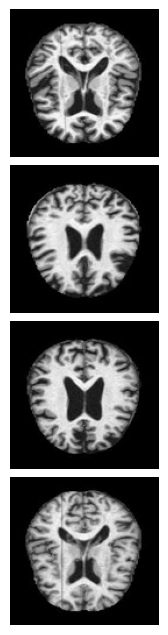

In [14]:
def plot_images(images, num_images=4, space=0.05, cmap='gray', vmax=None):
    plt.figure(figsize=(2, 8))
    for i in range(4):
        plt.subplot(4, 1, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap=cmap, vmax=vmax)
        plt.axis('off')
    plt.subplots_adjust(wspace=space, hspace=space)
    plt.show()

# Fixing the random seed for DataLoader
torch.manual_seed(42)

# Get a batch of images from the test set
test_iter = iter(test_loader)
images_batch, labels_batch = next(test_iter)

# Select the first 4 images to display
start_index = 0
images = images_batch[start_index:start_index+4]

plot_images(images, 0.05, vmax=1)

# print(len(train_loader))

### Corrupted images

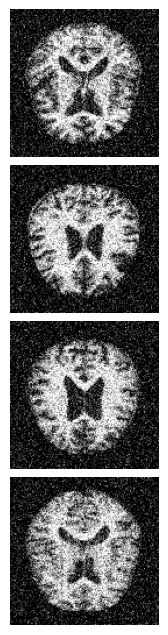

In [15]:
# torch_images = torch.stack(images)

noisy_images = add_gaussian_noise(images, noise_factor)
plot_images(noisy_images, space=0.05)

### Predictions DAE

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


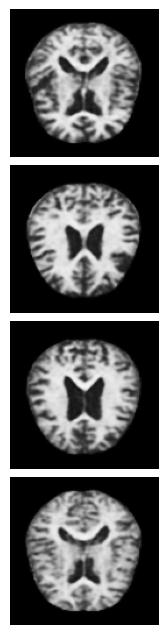

In [17]:
# noisy_images_flattened = noisy_images.view(noisy_images.size(0), -1).to(device)
traditional_convolutional_model.eval()
with torch.no_grad():
    _, predictions_mean, predictions_var = traditional_convolutional_model.sample_predict(noisy_images.to(device), 10)

plot_images(predictions_mean.view(-1,image_size,image_size).cpu(), space=0.05, vmax=1)

### Mean BDAE

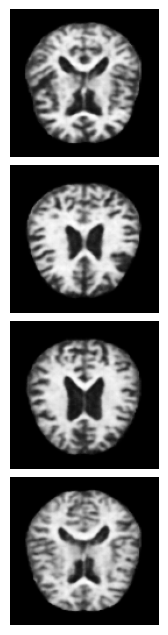

In [18]:
# noisy_images_flattened = noisy_images.view(noisy_images.size(0), -1).to(device)
bayesian_convolutional_model.eval()
with torch.no_grad():
    _, predictions_mean, predictions_var = bayesian_convolutional_model.sample_predict(noisy_images.to(device), 10)

plot_images(predictions_mean.view(-1,image_size,image_size).cpu(), space=0.05)

### Variance BDAE

0.00946788


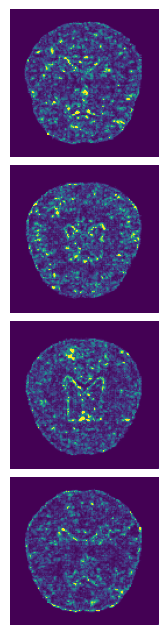

In [21]:
max_pixel = np.max(predictions_var.cpu().numpy()[:4])
print(max_pixel)

plot_images(predictions_var.view(-1,image_size,image_size).cpu(), space=0.05, cmap='viridis', vmax=0.0030607605)

# plt.figure(figsize=(2, 8))
# for i in range(num_images):
#     plt.subplot(4, 1, i + 1)
#     plt.imshow(predictions_var[i].cpu().numpy().squeeze(), cmap='viridis', vmax=0.12)
#     plt.axis('off')
# # plt.subplots_adjust(wspace=space, hspace=space)
# plt.show()